In [1]:
!pip install transformers sentencepiece sentence_transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 62.1 MB/s 
     |████████████████████████████████| 85 kB 5.3 MB/s 
     |████████████████████████████████| 365 kB 68.5 MB/s 
     |████████████████████████████████| 101 kB 13.1 MB/s 
     |████████████████████████████████| 596 kB 48.1 MB/s 
     |████████████████████████████████| 6.6 MB 53.5 MB/s 
     |████████████████████████████████| 212 kB 66.9 MB/s 
     |████████████████████████████████| 141 kB 73.3 MB/s 
     |████████████████████████████████| 127 kB 75.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=6b6c75e2182c071e52c32d9ac5471cd23ddaa6a1e854cc648a7e5b5bd2817ee5
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transfor

In [18]:
import torch

In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [104]:
model_name = 'doc2query/msmarco-t5-base-v1'

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [105]:
import datasets

dataset = datasets.load_dataset("aquamuse", "abstractive")

Generating train split:   0%|          | 0/6253 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/811 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/661 [00:00<?, ? examples/s]

Dataset aquamuse downloaded and prepared to /root/.cache/huggingface/datasets/aquamuse/abstractive/2.3.0/8d8ba8a1c639417cfd77d6734094d085e832ceded99cebdc5a484d1a45b4c134. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [106]:
dataset.keys()

dict_keys(['train', 'test', 'validation'])

In [107]:
passages = []

for split in dataset.keys():
  for d in dataset[split]:
    passages.append(d["target"])

len(passages)

7725

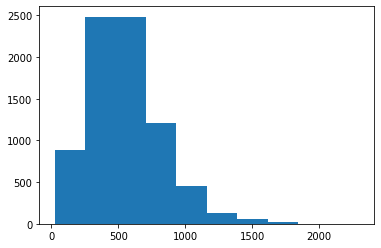

In [108]:
import matplotlib.pyplot as plt

plt.hist([len(txt) for txt in passages]);

In [109]:
def generate_questions(tokenizer, model, passages, batch_size=32, device="cuda"):
  outputs = []

  n_batches = len(passages) // batch_size + int(len(passages) % batch_size != 0)
  for n in range(n_batches):
    if n > 0 and n % 5 == 0:
      print(f"{n:>3}/{n_batches}")
    passages_batch = passages[n*batch_size: (n+1)*batch_size]
    inputs = tokenizer(passages_batch, padding=True, truncation=True,
                       max_length=512, return_tensors='pt')
    output = model.generate(
        input_ids=inputs['input_ids'].to(device),
        attention_mask=inputs['attention_mask'].to(device),
        max_length=64,
        do_sample=True,
        top_p=0.95,
        num_return_sequences=3
    )
    outputs += output

  questions = [tokenizer.decode(txt, skip_special_tokens=True) for txt in outputs]
  return questions

In [110]:
questions = generate_questions(tokenizer, model, passages)

  5/242
 10/242
 15/242
 20/242
 25/242
 30/242
 35/242
 40/242
 45/242
 50/242
 55/242
 60/242
 65/242
 70/242
 75/242
 80/242
 85/242
 90/242
 95/242
100/242
105/242
110/242
115/242
120/242
125/242
130/242
135/242
140/242
145/242
150/242
155/242
160/242
165/242
170/242
175/242
180/242
185/242
190/242
195/242
200/242
205/242
210/242
215/242
220/242
225/242
230/242
235/242
240/242


In [116]:
questions[:9]

['who was the first female rajya Sabha member',
 'who is the first woman to be nominated as a rajya sabaha',
 'what type of dancing style was sanghartha mahna originally in',
 'the number of h3 horsepower',
 'how many hp does the h3 sport get',
 'what engine does a new h3 have',
 'is 24 karat gold pure',
 'what is pure gold',
 'what is 95% pure gold']

In [128]:
q2pix = {}

pix = 0
for i in range(len(questions)):
  if i > 0 and i % 3 == 0:
    pix += 1
  q2pix[questions[i]] = pix

In [130]:
q2pix[questions[0]]

0

In [131]:
unique_questions = list(set(questions))
len(unique_questions)

22255

In [171]:
import numpy as np
from sentence_transformers import SentenceTransformer, util

retriever = SentenceTransformer('msmarco-distilbert-base-tas-b', device="cuda")

In [172]:
passage_embeddings = retriever.encode(passages)

In [203]:
def get_topk_passages(model, query, passage_embeds, n=10):
  query_embed = model.encode(query)
  sim_scores = util.cos_sim(query_embed, passage_embeds).numpy()
  top_passages_ix = np.argsort(sim_scores)[0][::-1][:n]
  return top_passages_ix, [sim_scores[0][ix] for ix in top_passages_ix]

In [174]:
unique_questions[10], passages[q2pix[unique_questions[10]]]

('who was the architect of the titanic',
 'RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early hours of 15 April 1912, after colliding with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. It was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.')

In [175]:
len(passages)

7725

In [176]:
query_passage_pairs = []

for query in unique_questions:
  top_passages_ixs = get_topk_passages(retriever, query, passage_embeddings, 3)
  query_passage_pairs += [(query, passages[ix]) for ix in top_passages_ixs if ix != q2pix[query]]

In [177]:
len(query_passage_pairs)

47022

In [215]:
query_passage_pairs[103], passages[q2pix[query_passage_pairs[103][0]]]

(('who played emperor palpatine in return of jedi',
  'The character was created by George Lucas and has been portrayed by numerous actors. His appearances span the first six Star Wars films, as well as Rogue One, and his character is referenced in both Star Wars: The Force Awakens and Star Wars: The Last Jedi. He is also an important character in the Star Wars expanded universe of television series, video games, novels, literature and comic books. Originally a Jedi prophesied to bring balance to the Force, Anakin is lured to the dark side of the Force by Palpatine, at the time the Supreme Chancellor of the Galactic Republic and secretly the Sith Lord Darth Sidious. He then serves the Galactic Empire as Vader at the right hand of Emperor Palpatine until his redemption after encountering his son, Luke Skywalker. Biologically, he is also the father of Princess Leia Organa, the secret husband of Padmé Amidala before his fall, and grandfather of Kylo Ren.'),
 "After a minor part in the fil

In [179]:
torch.cuda.empty_cache()

In [180]:
from sentence_transformers import CrossEncoder

ce = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device="cuda")

In [183]:
query_passage_margins = []

for i, (query, passage) in enumerate(query_passage_pairs):
    if i % 100 == 0:
      print(i)
    # predict (Q, P+) and (Q, P-) scores
    p_score = ce.predict((query, passages[q2pix[query]]))
    n_score = ce.predict((query, passage))
    # calculate the margin score
    margin = p_score - n_score
    query_passage_margins.append((query, passages[q2pix[query]], passage, margin))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [192]:
from sentence_transformers import InputExample, losses

In [185]:
training_data = []
for query, passage_pos, passage_neg, margin in query_passage_margins:
  training_data.append(InputExample(texts=[query, passage_pos, passage_neg], label=float(margin)))

In [187]:
loader = torch.utils.data.DataLoader(training_data, batch_size=16, shuffle=True)

In [188]:
torch.cuda.empty_cache()

In [189]:
model = SentenceTransformer('msmarco-distilbert-base-tas-b', device="cuda")
model.max_seq_length = 512

In [193]:
loss = losses.MarginMSELoss(model)

In [194]:
model.fit(train_objectives=[(loader, loss)],
          epochs=1,
          warmup_steps=int(len(loader)*0.1),
          show_progress_bar=True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2939 [00:00<?, ?it/s]

In [195]:
new_passage_embeddings = model.encode(passages)

In [196]:
import random

In [ ]:
random.sample(passages, 1)

In [279]:
# query = "what is oceans 8"
# query = "what is the dress"

top_passages_ixs, scores = get_topk_passages(model, query, new_passage_embeddings, 3)
for ix, score in zip(top_passages_ixs, scores):
  print(score, passages[ix], "\n")

0.8479493 "The dress" is a photograph that became a viral Internet meme on 26 February 2015, when viewers disagreed over whether the colours of the item of clothing depicted were black and blue or white and gold. The phenomenon revealed differences in human colour perception which have been the subject of ongoing scientific investigation in neuroscience and vision science, with a number of papers published in peer-reviewed science journals. 

0.83107686 A denim skirt, sometimes referred to as a' jean skirt' or' jeans skirt', is a skirt made of denim, the same material as blue jeans. Denim skirts come in a variety of styles and lengths to suit different populations and occasions. For example, full-length denim skirts are commonly worn by women whose religious beliefs prohibit them from wearing trousers, including Orthodox Jews, some Muslims, Mennonites, and Pentecostals, among others. Shorter skirts made of denim are commonly worn by teenagers and young adults. 

0.8290126 The term orig

In [280]:
# retriever = SentenceTransformer('msmarco-distilbert-base-tas-b')

In [281]:
top_passages_ixs, scores = get_topk_passages(retriever, query, passage_embeddings, 3)
for ix, score in zip(top_passages_ixs, scores):
  print(score, passages[ix], "\n")

0.8381401 The term originates from the white colour of the wedding dress, which first became popular with Victorian era elites after Queen Victoria wore a white lace dress at her wedding. However, the term now also encapsulates the entire Western wedding routine, especially in the Christian religious tradition, which generally includes a ceremony during which the marriage begins, followed by a reception. 

0.8374766 A denim skirt, sometimes referred to as a' jean skirt' or' jeans skirt', is a skirt made of denim, the same material as blue jeans. Denim skirts come in a variety of styles and lengths to suit different populations and occasions. For example, full-length denim skirts are commonly worn by women whose religious beliefs prohibit them from wearing trousers, including Orthodox Jews, some Muslims, Mennonites, and Pentecostals, among others. Shorter skirts made of denim are commonly worn by teenagers and young adults. 

0.8162099 "The dress" is a photograph that became a viral Int